In [1]:
# The MIT License (MIT) Copyright (c) 2025 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/10_Word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Word embeddings
- Word Embeddings es una técnica popular en procesamiento del lenguaje natural que permite representar las palabras en un espacio vectorial.
  
- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [2]:
import torch
import pandas as pd

torch.__version__

'2.5.1+cu124'

In [3]:
torch.manual_seed(77)

## 1.- Conjuntos de entrenamiento y validación

In [4]:
df = pd.read_csv('./cyberbullying_tweets.csv')   

In [5]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [7]:
# Contar elementos por clase
count = df['cyberbullying_type'].value_counts()
count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [8]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 1,
    'other_cyberbullying': 1,
    'age': 1,
    'ethnicity': 1
}

df['cyberbullying_type'] = df['cyberbullying_type'].map(labels_dict)
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [9]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
df['tweet_text'] = df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,0
1,why is aussietv so white mkr theblock imaceleb...,0
2,xochitlsuckkks a classy whore or more red velv...,0
3,jasongio meh p thanks for the heads up but no...,0
4,rudhoeenglish this is an isis account pretendi...,0


In [11]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
1    39747
0     7945
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

X = df['tweet_text']
y = df['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train and 20% test
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (38153,), Test shape: (9539,)


## 2.- Pipeline

- Crea vocabulario y define tokenizer.

In [13]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

# Define a WordLevel tokenizer with unk_token
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Create a WordLevelTrainer and specify special tokens (including [UNK])
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]"], min_frequency=1)


# Train the tokenizer on your text data, using the trainer
tokenizer.train_from_iterator(X, trainer=trainer)

# Now you can encode your text
text = "Hello, how are you?"
encoding = tokenizer.encode(text)

# Access the token IDs
print("Token IDs:", encoding.ids)

# Decode the token IDs back to words
decoded_text = tokenizer.decode(encoding.ids)
print("Decoded Text:", decoded_text)

Token IDs: [0, 0, 72, 13, 7, 0]
Decoded Text: how are you


In [14]:
vocab_size = tokenizer.get_vocab_size()
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 30000


In [15]:
PAD_IDX = tokenizer.token_to_id("[PAD]") 
PAD_IDX

1

In [16]:
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode(text)
        input_ids = encoding.ids

        # Padding
        padding_length = self.max_len - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + ([tokenizer.token_to_id("[PAD]")] * padding_length)
        elif padding_length < 0:
            input_ids = input_ids[:self.max_len]

        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.float32)


# Crea los datasets
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(),
                                     tokenizer, max_len=64)
val_dataset = TextDataset(X_test.tolist(), y_test.tolist(),
                                    tokenizer, max_len=64)

# Crea los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [17]:
%%timeit
train_batch, target_batch = next(iter(train_loader))

4.46 ms ± 67.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
train_batch, target_batch = next(iter(train_loader))

In [19]:
train_batch.shape, target_batch.shape

(torch.Size([128, 64]), torch.Size([128]))

## 3.- Modelo

In [20]:
import torch.nn as nn

In [21]:
class Model(nn.Module):
    def __init__(self, vocab_size):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(128, 16)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu3 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x = torch.permute(x, (0, 2, 1))
        x = self.pooling(x).squeeze()
        x = self.relu1(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        x = self.relu3(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = Model(vocab_size)
output_batch = model(train_batch)

In [22]:
output_batch.shape, output_batch.squeeze().shape

(torch.Size([128, 1]), torch.Size([128]))

## 4.- Entrenamiento

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda:0


Model(
  (embedding): Embedding(30000, 128)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (relu1): ReLU()
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (relu3): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [24]:
from torch import optim

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

In [26]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [27]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = loss_fn(outputs, labels)
            outputs = torch.round(outputs)
            running_acc += outputs.eq(labels).sum().item()
            running_loss += loss.item()

    print(f'Time for eval is {time.time()-start:.4f} sec Val loss: {running_loss / len(test_loader):.4f}')
    print(f'Val acc: {running_acc / len(test_loader.dataset):.4f}')

In [28]:
import time

In [29]:
epochs = 7

for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)


Time for epoch 0 is 1.7238 sec Train loss: 0.4648
Time for eval is 0.3251 sec Val loss: 0.3707
Val acc: 0.8298

Time for epoch 1 is 1.6010 sec Train loss: 0.3232
Time for eval is 0.2923 sec Val loss: 0.3114
Val acc: 0.8461

Time for epoch 2 is 1.5089 sec Train loss: 0.2763
Time for eval is 0.2918 sec Val loss: 0.2907
Val acc: 0.8589

Time for epoch 3 is 1.5303 sec Train loss: 0.2489
Time for eval is 0.3074 sec Val loss: 0.2782
Val acc: 0.8629

Time for epoch 4 is 1.5418 sec Train loss: 0.2276
Time for eval is 0.3100 sec Val loss: 0.2922
Val acc: 0.8648

Time for epoch 5 is 1.5772 sec Train loss: 0.2120
Time for eval is 0.2929 sec Val loss: 0.3022
Val acc: 0.8381

Time for epoch 6 is 1.4736 sec Train loss: 0.1955
Time for eval is 0.3103 sec Val loss: 0.3093
Val acc: 0.8624


## 5.- Vectores

In [30]:
# Define the list of words
words = ["bad", "good", "hate", "happy", "love", "scared", "friend", "sad", 
         "alive", "family", "confident", "fight", "live", "funny", "best", 
         "great", "amazing"]

# Convert words to token IDs
words_ids = torch.tensor([tokenizer.encode(word).ids[0] for word in words], dtype=torch.long)

words_ids


tensor([ 177,  143,  134,  464,  162,  820,  316,  543, 1191,  407, 2780,  371,
         404,  183,  327,  375,  793])

In [31]:
model.to('cpu')
model.eval()

Model(
  (embedding): Embedding(30000, 128)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (relu1): ReLU()
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (relu3): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [32]:
embeddings = model.embedding(words_ids).detach()
embeddings.shape

torch.Size([17, 128])

- Visualización de los vectores aprendidos

(17, 2)


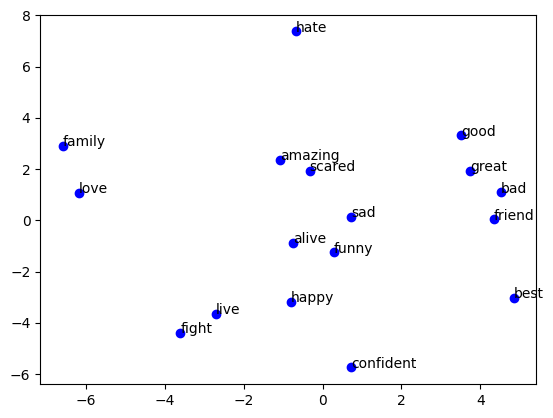

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
print(pca_embeddings.shape)

# Plot embeddings using matplotlib
fig, ax = plt.subplots()
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))
    
plt.show()